In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import torch
import numpy as np 
import nibabel as nib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!unzip /kaggle/input/finding-lungs-in-ct-data/3d_images.zip

Archive:  /kaggle/input/finding-lungs-in-ct-data/3d_images.zip
 extracting: IMG_0002.nii.gz         
 extracting: IMG_0031.nii.gz         
 extracting: IMG_0059.nii.gz         
 extracting: IMG_0078.nii.gz         
 extracting: MASK_0002.nii.gz        
 extracting: MASK_0031.nii.gz        
 extracting: MASK_0059.nii.gz        
 extracting: MASK_0078.nii.gz        


In [3]:
data_dir="/kaggle/working/"

In [4]:
images = sorted(glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))

print('No. of images: ', len(images), 'labels: ', len(labels))

No. of images:  4 labels:  4


In [5]:
img = nib.load(images[0]).get_fdata()
lbl = nib.load(labels[0]).get_fdata()
print('\nimg shape: ', img.shape, 'lbl shape: ', lbl.shape)
print('img intensity min.: ', np.min(img), 'max.: ', np.max(img), 'unique labels: ', np.unique(lbl))


img shape:  (325, 512, 512) lbl shape:  (325, 512, 512)
img intensity min.:  -933.0 max.:  2675.0 unique labels:  [  0. 255.]


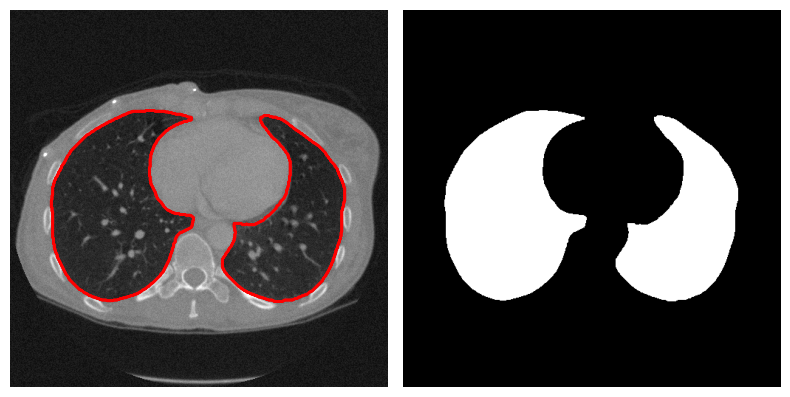

In [6]:
slice_idx = 100

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
plt.contour(lbl[slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

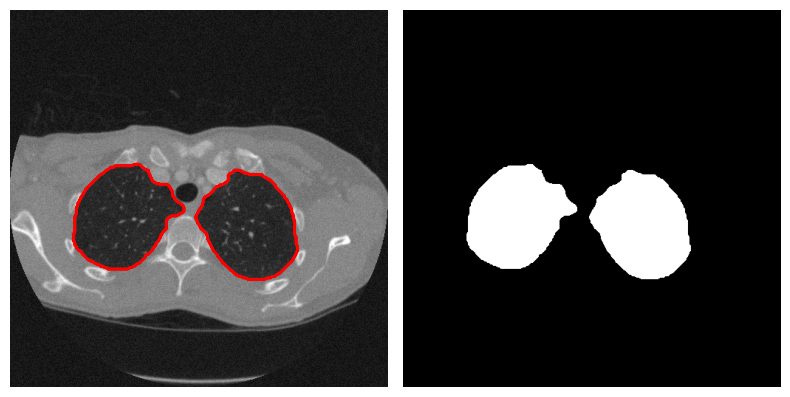

In [7]:
slice_idx = 250

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
plt.contour(lbl[slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
!pip install scikit-image

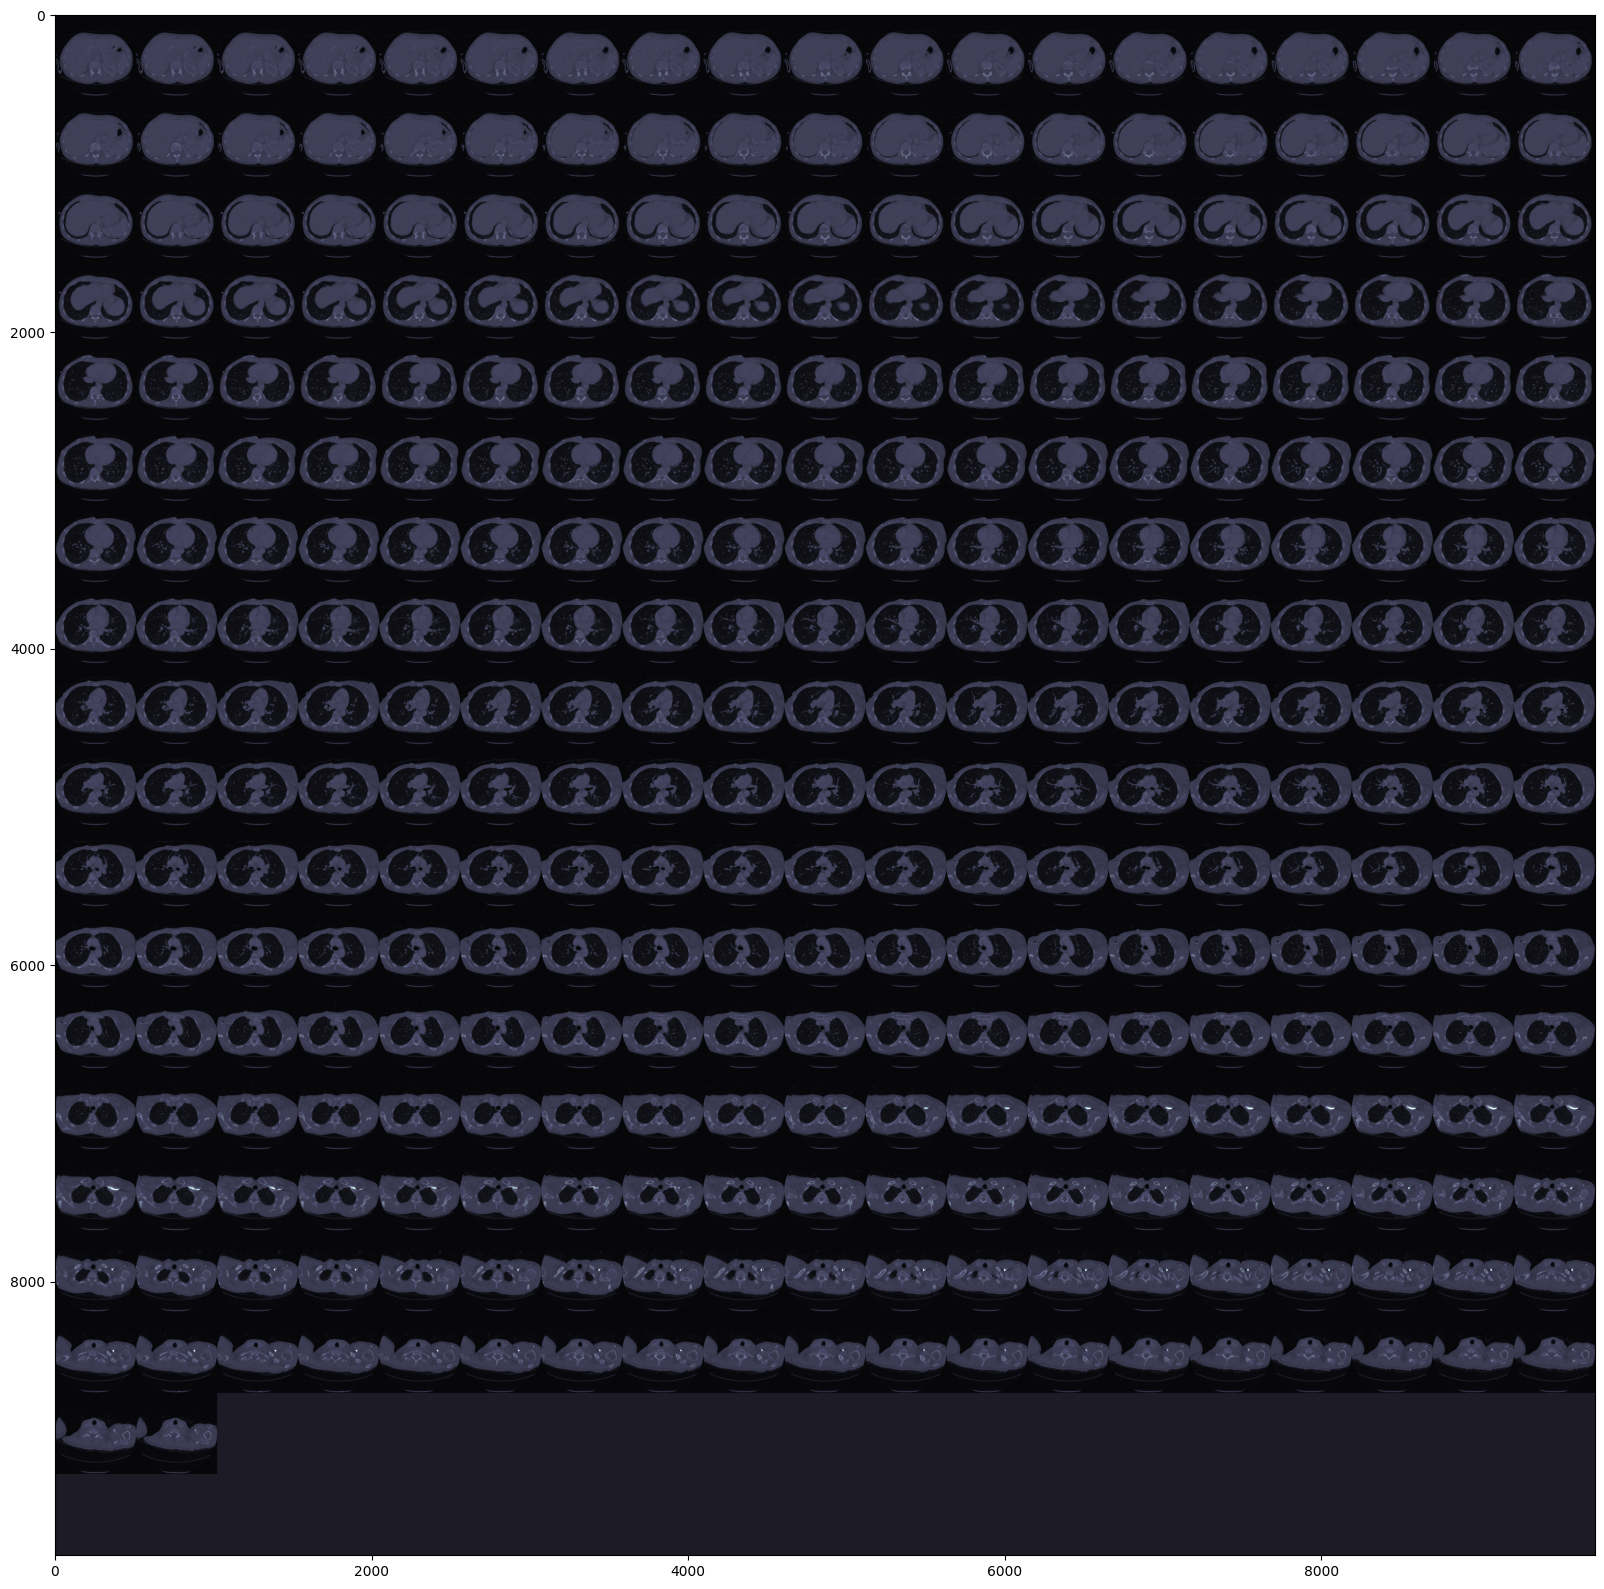

In [9]:
from skimage.util import montage as montage2d
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage2d(img), cmap ='bone')
fig.savefig('ct_scan.png')

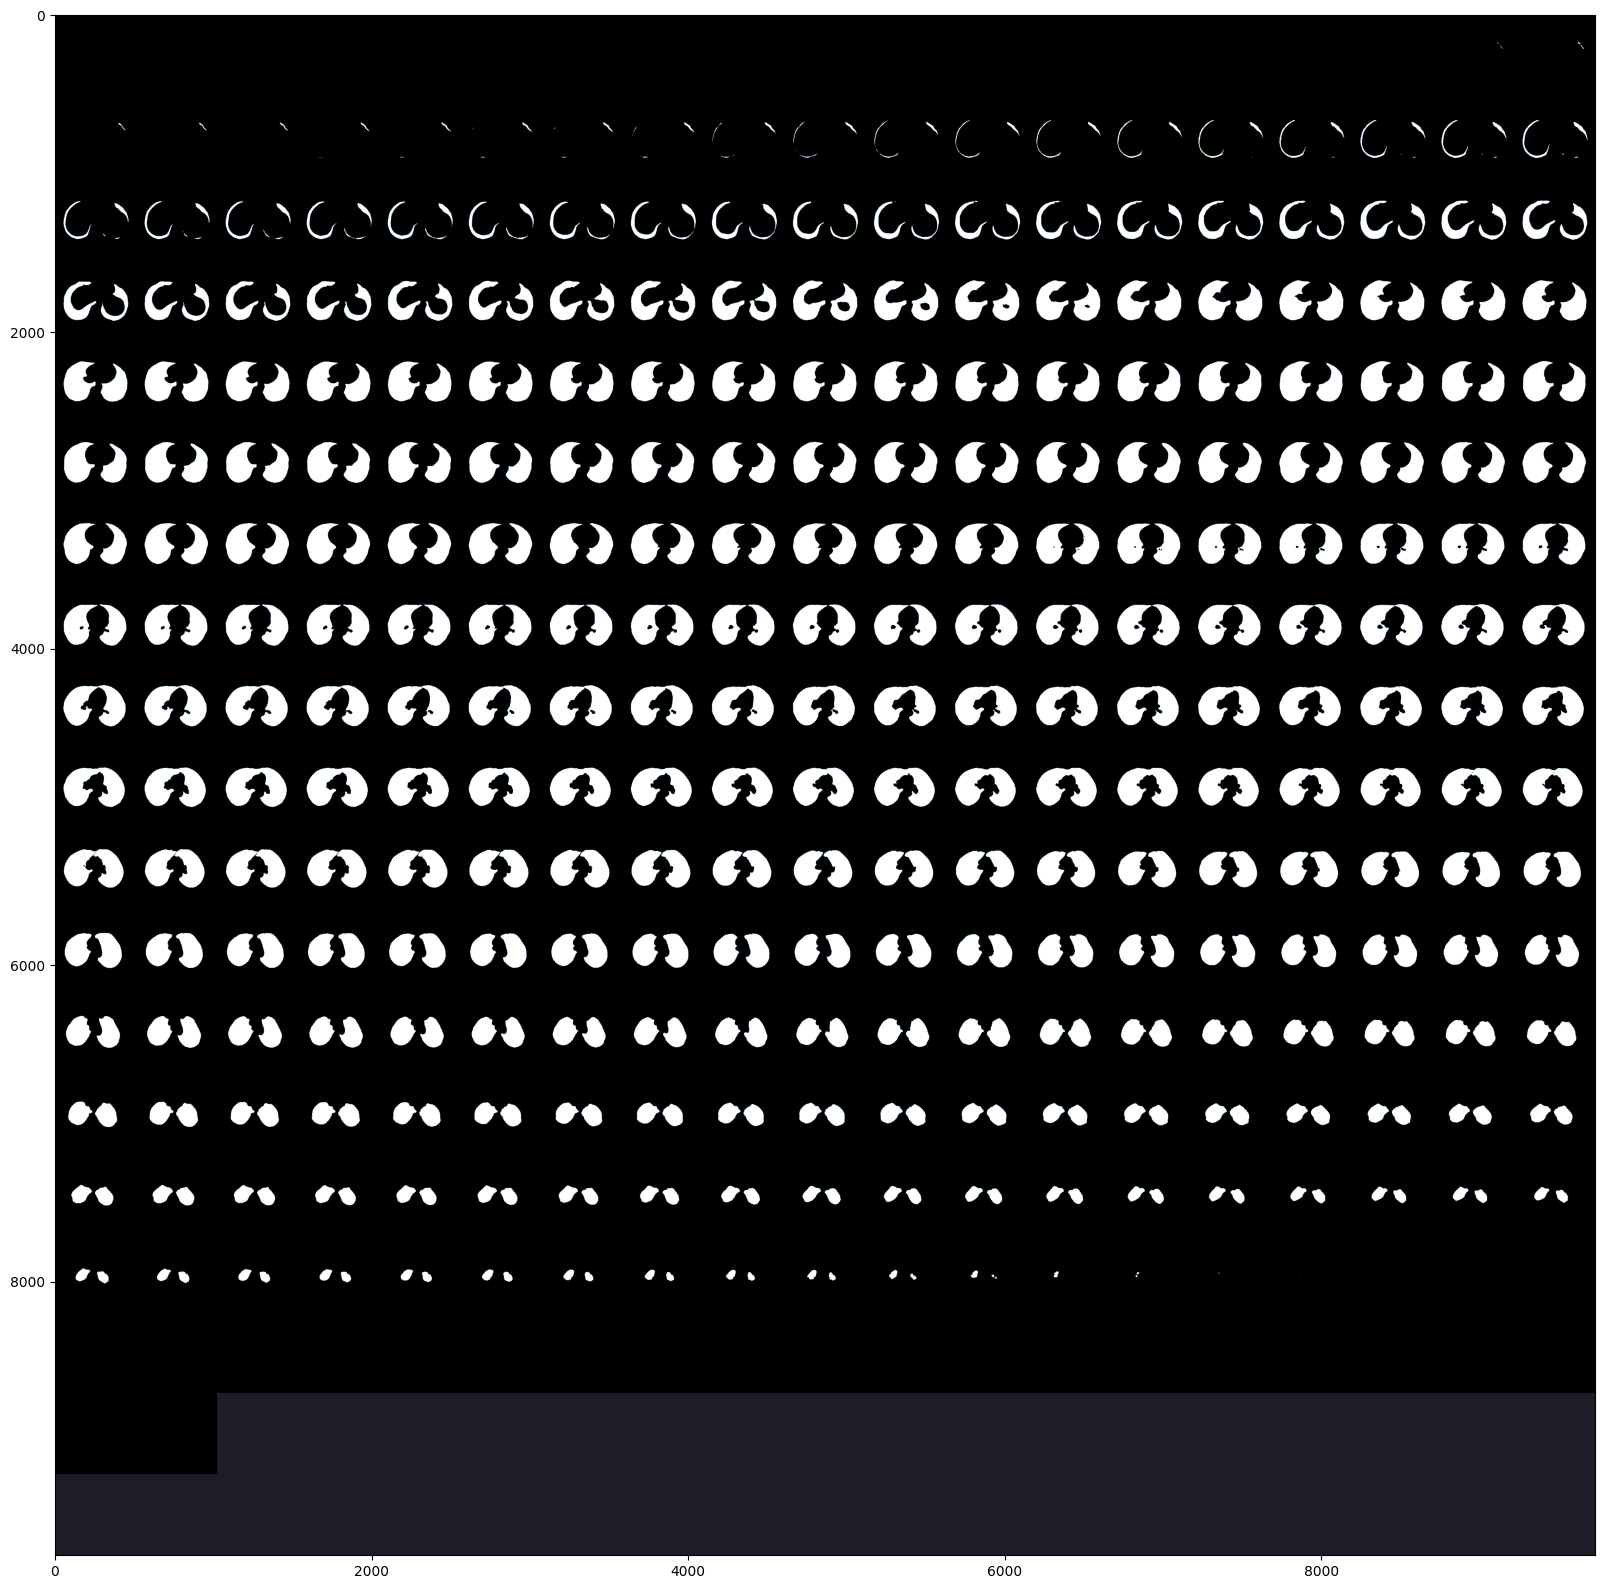

In [10]:
fig, ax1 = plt.subplots(1,1, figsize = (20, 20))
ax1.imshow(montage2d(lbl), cmap ='bone')
fig.savefig('lung_mask.png')

In [11]:
data_dicts = [
    {'image': image_name, 'label': label_name}
    for image_name, label_name in zip(images, labels)
]

train_files, val_files, test_files = data_dicts[:2], data_dicts[2:3], data_dicts[-1:]

print('train files: ', len(train_files), 'val files: ', len(val_files), 'test files: ', len(test_files))

train files:  2 val files:  1 test files:  1


##  MONAI(Medical Open Network for AI)
### 의료 영상 처리를 위한 프레임워크

In [12]:
!pip install monai
from monai.utils import first, set_determinism

set_determinism(seed=0)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.9 MB/s eta 0:00:00


2024-02-28 07:25:19.772679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 07:25:19.772780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 07:25:19.943121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

train_transforms = Compose(
    [
        # 이미지 파일을 메모리에 로드
        LoadImaged(keys = ['image', 'label']),
        # 이미지 데이터의 채널 축을 첫 번째 축으로 변경
        EnsureChannelFirstd(keys = ['image', 'label']),
        # 이미지 데이터의 픽셀 값을 지정된 범위로 스케일링  '-1000'에서 '1000' 사이의 값을 '0'에서 '1' 사이로 스케일링하고, 
        ScaleIntensityRanged(
            keys=['image'], a_min = -1000, a_max = 1000,
            b_min = 0.0, b_max = 1.0, clip=True,),
        
        # 레이블 데이터의 경우 '0'에서 '255' 사이의 값을 '0'에서 '1' 사이로 스케일링
        ScaleIntensityRanged(
            keys=['label'], a_min = 0, a_max = 255,
            b_min = 0.0, b_max = 1.0, clip = True,),
        # 전경을 기준으로 이미지를 잘라냄. 이는 이미지 주변의 불필요한 부분을 제거하고 관심 영역을 보다 효과적으로 처리
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # 이미지 방향 조정
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        # 이미지의 각 픽셀의 간격 조정
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        
        # R이미지와 레이블을 무작위로 자음. 여기서는 크기가 '96 x 96 x 96'인 패치를 무작위로 자름
        RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[96, 96, 96],
                random_size=False,
        ),
     
        # Data augmentation
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ])
    
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ])

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


### Sample

img shape: torch.Size([96, 96, 96]), lbl shape: torch.Size([96, 96, 96])


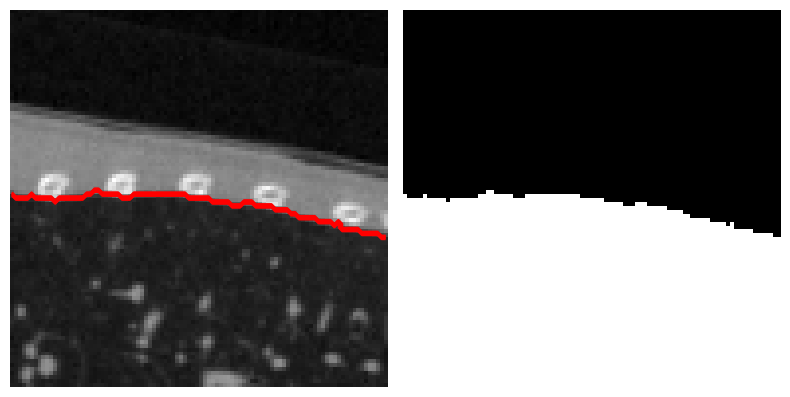

In [14]:
sample_ds = Dataset(data = train_files, transform = train_transforms)
sample_dataloader = DataLoader(sample_ds, batch_size = 1)
sample_batch = first(sample_dataloader)

img, lbl = sample_batch["image"][0][0], sample_batch["label"][0][0]
print(f"img shape: {img.shape}, lbl shape: {lbl.shape}")

slice_idx = 64
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,slice_idx], cmap='gray')
plt.contour(lbl[:,:,slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[:,:,slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1)

Loading dataset: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


In [16]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3, # 3d 이미지를 처리
    in_channels=1,
    out_channels=2, # 2 if using Softmax activation, 1 if using Sigmoid
    channels=(16, 32, 64, 128, 256), # 네트워크의 각 레이어에서의 특징 맵의 채널 수 정의
    strides=(2, 2, 2, 2), # 각 레이어에서의 스트라이드 의미
    num_res_units=2, # 각 레이어에서 잔차 유닛 수
    norm=Norm.BATCH, # 정규화 방법: Batch Normalization
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True) # Dice Loss는 segmentation 작업에서 주로 사용되며, 예측된 마스크와 실제 마스크 간의 유사성을 측정
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean") # 예측된 마스크와 실제 마스크 간의 유사성을 측정

In [17]:
from monai.inferers import sliding_window_inference

# Define hyperparameters
max_epochs = 500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Define post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Training loop
for epoch in range(max_epochs):
    print("-" * 20, f"epoch {epoch + 1}/{max_epochs}", "-" * 20)
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:

                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device),
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 1, model)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

-------------------- epoch 1/500 --------------------
1/1, train_loss: 0.5442
epoch 1 average loss: 0.5442
-------------------- epoch 2/500 --------------------
1/1, train_loss: 0.5001
epoch 2 average loss: 0.5001
saved new best metric model
current epoch: 2 current mean dice: 0.2778
best mean dice: 0.2778 at epoch: 2
-------------------- epoch 3/500 --------------------
1/1, train_loss: 0.5447
epoch 3 average loss: 0.5447
-------------------- epoch 4/500 --------------------
1/1, train_loss: 0.5211
epoch 4 average loss: 0.5211
current epoch: 4 current mean dice: 0.2776
best mean dice: 0.2778 at epoch: 2
-------------------- epoch 5/500 --------------------
1/1, train_loss: 0.5643
epoch 5 average loss: 0.5643
-------------------- epoch 6/500 --------------------
1/1, train_loss: 0.5853
epoch 6 average loss: 0.5853
current epoch: 6 current mean dice: 0.2778
best mean dice: 0.2778 at epoch: 2
-------------------- epoch 7/500 --------------------
1/1, train_loss: 0.4435
epoch 7 average lo

train completed, best_metric: 0.9615 at epoch: 490


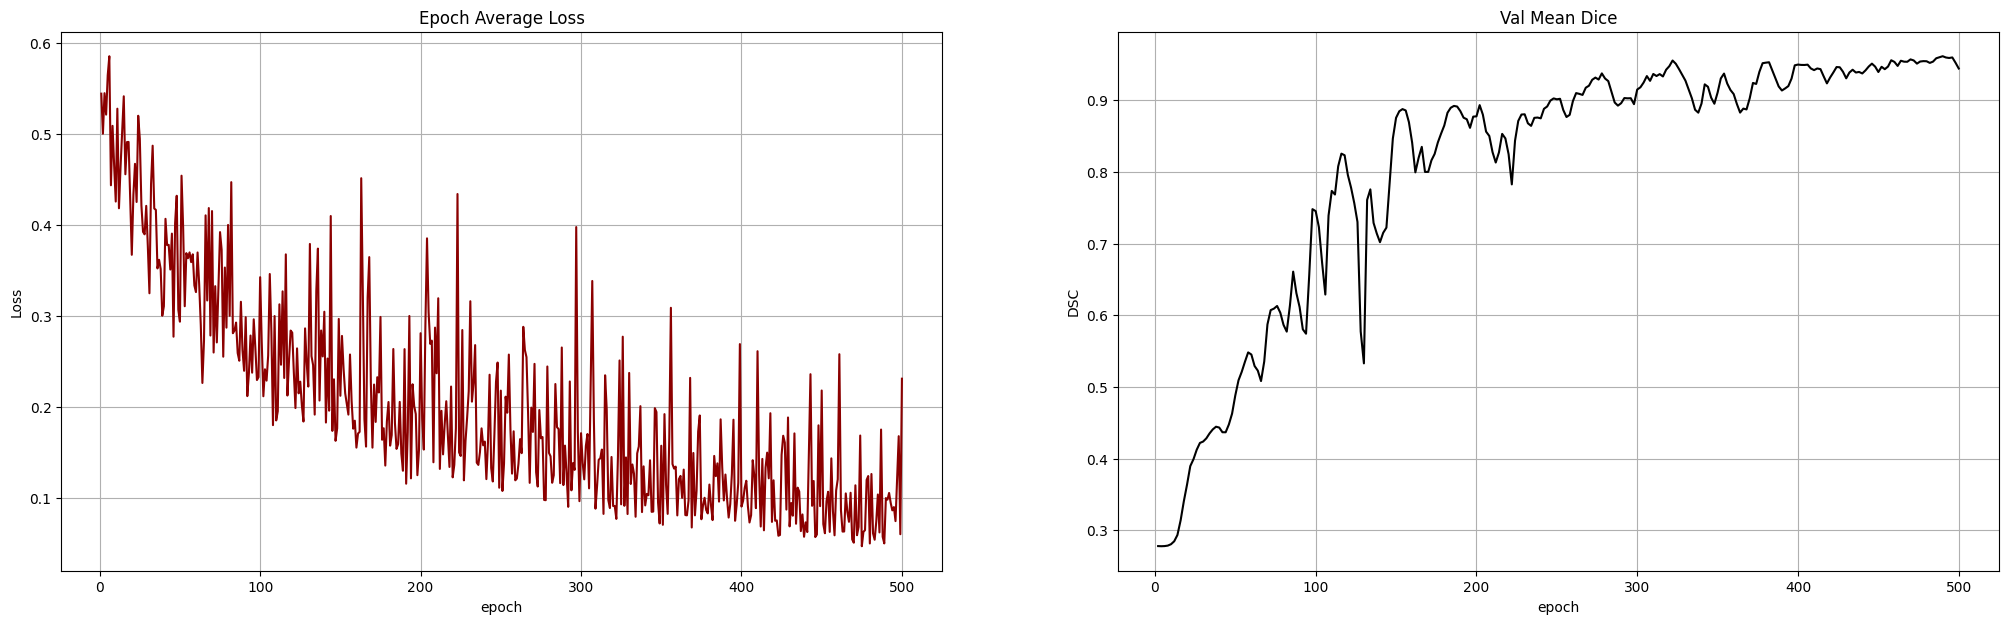

In [18]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

plt.figure("train", (25,7))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.plot(x, y, color='darkred')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.ylabel("DSC")
plt.xlabel("epoch")
plt.grid(True)
plt.plot(x, y, color='black')
plt.show()

In [19]:
test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=val_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

2024-02-28 07:33:42,247 INFO image_writer.py:197 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


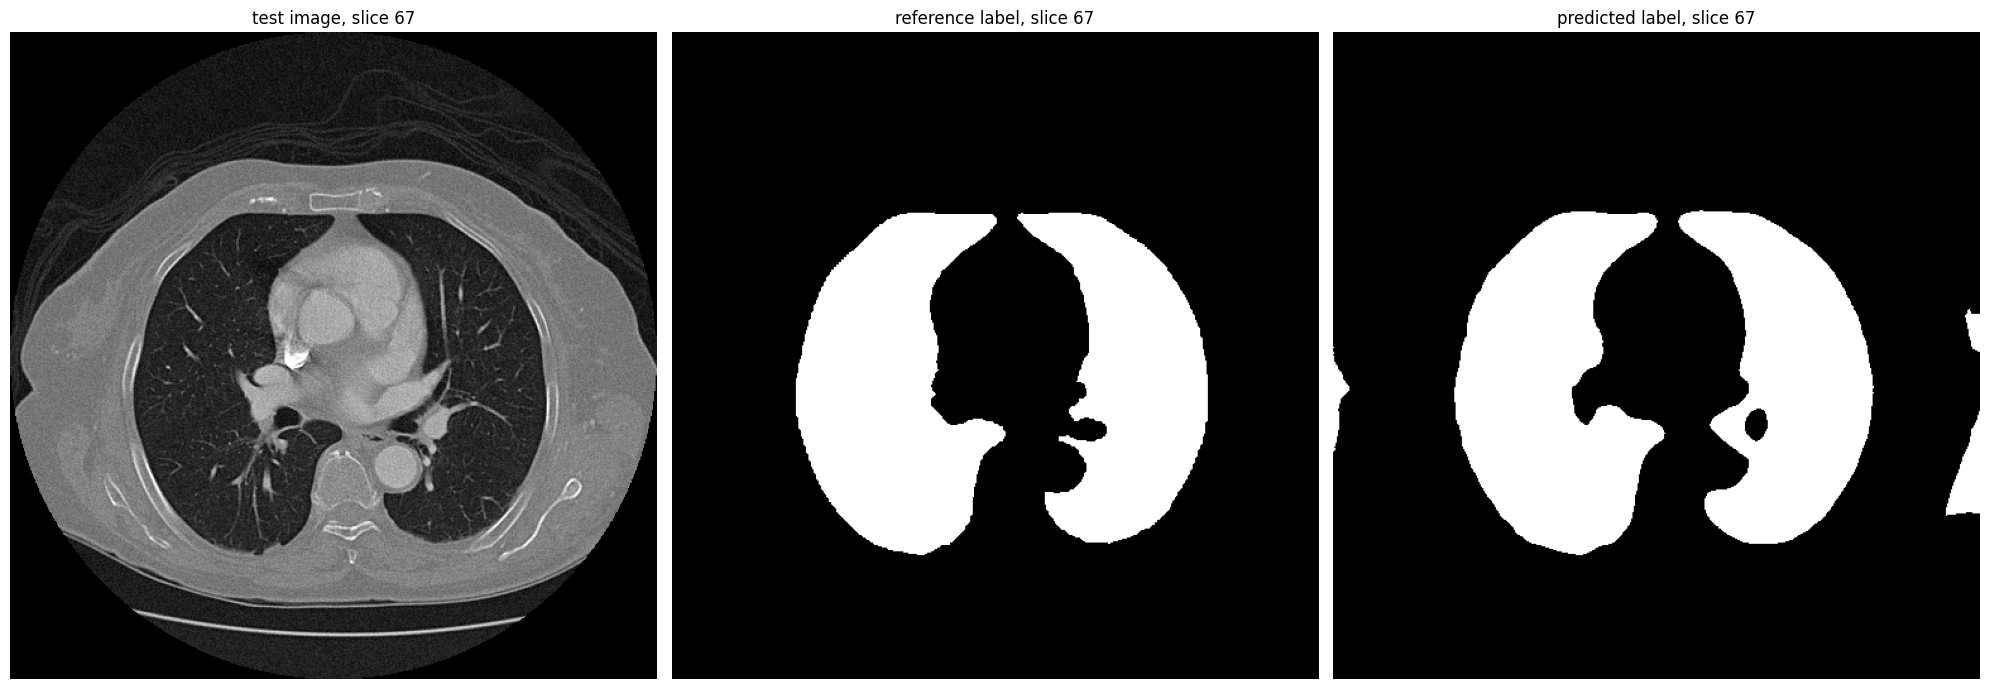

In [20]:
from monai.transforms import LoadImage
from monai.handlers.utils import from_engine

loader = LoadImage()

model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_files[0]['image']) # Load the original image
        original_label = loader(test_files[0]['label']) # Load the original label

        slice_idx = 67

        plt.figure(figsize=(20,7))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.title(f'test image, slice {slice_idx}')
        plt.imshow(original_image.detach().cpu().numpy()[slice_idx], cmap="gray", vmin=-1000, vmax=1000)
        plt.subplot(1, 3, 2)
        plt.title(f'reference label, slice {slice_idx}')
        plt.axis('off')
        plt.imshow(original_label.detach().cpu().numpy()[slice_idx], cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title(f'predicted label, slice {slice_idx}')
        plt.axis('off')
        plt.imshow(test_output[0].detach().cpu().numpy()[1,slice_idx], cmap="gray") # use index 1 to get the lung class
        plt.tight_layout()
        plt.show()

2024-02-28 07:33:59,456 INFO image_writer.py:197 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


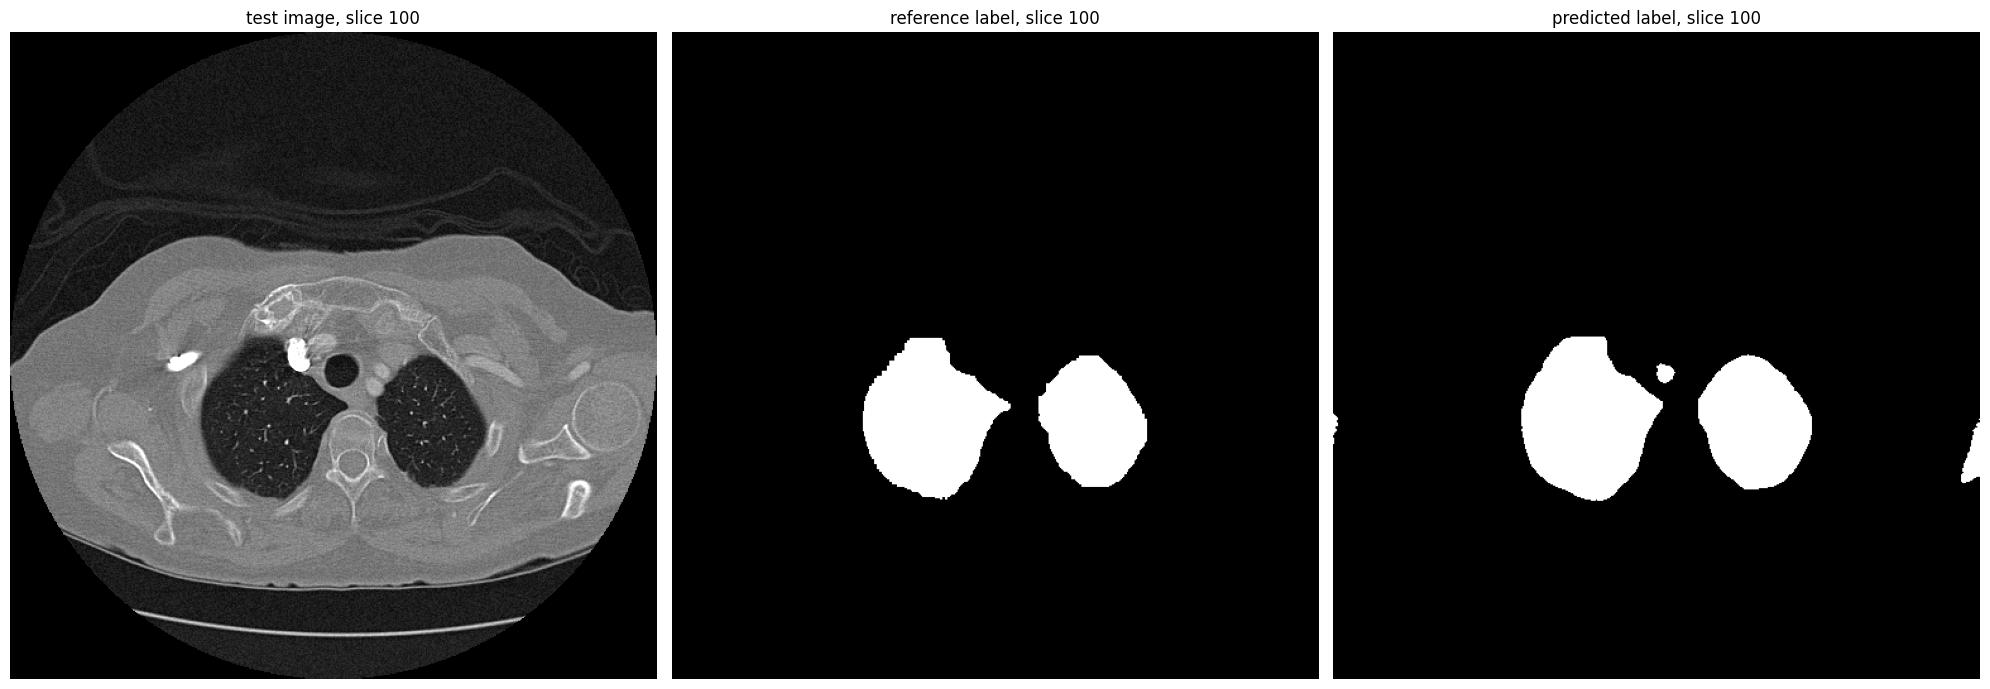

In [21]:
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_files[0]['image']) # Load the original image
        original_label = loader(test_files[0]['label']) # Load the original label

        slice_idx = 100

        plt.figure(figsize=(20,7))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.title(f'test image, slice {slice_idx}')
        plt.imshow(original_image.detach().cpu().numpy()[slice_idx], cmap="gray", vmin=-1000, vmax=1000)
        plt.subplot(1, 3, 2)
        plt.title(f'reference label, slice {slice_idx}')
        plt.axis('off')
        plt.imshow(original_label.detach().cpu().numpy()[slice_idx], cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title(f'predicted label, slice {slice_idx}')
        plt.axis('off')
        plt.imshow(test_output[0].detach().cpu().numpy()[1,slice_idx], cmap="gray") # use index 1 to get the lung class
        plt.tight_layout()
        plt.show()